In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tflearn
from sklearn import linear_model as lm, neural_network as nn
import sklearn.preprocessing as preproc
import sklearn.model_selection as modselect

original_dir = os.getcwd()

In [3]:
PLOT=True

In [4]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [5]:
import pywt
# import pyhht

In [6]:
from imp import reload
import glob

In [7]:
os.chdir('/home/mike/ve/ml')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics, msig, auxfilter

/home/mike/ve/ml


In [8]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [9]:
matplotlib.style.use('ggplot')

In [10]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

In [11]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [12]:
def janky_subdiv(data, subdiv=64, chanVecSize=1024, nChan=16):
    if data.ndim == 3:
        return data[:,::subdiv,:].reshape(-1,chanVecSize*nChan//subdiv)
    elif data.ndim == 2:
        return data[:,::subdiv]
    else:
        raise NotImplementedError("d'oh!")

Data loading section

In [14]:
# basedir = '/run/media/mike/Elements/data/kaggle/melbourne/vectors/'
basedir = '/home/mike/data/vectors/'

data_train = np.load(basedir + 'vec_1478816228.31.npy')
names_train = pd.read_csv(basedir + 'vec_1478816228.31_name.csv')
data_test = np.load(basedir + 'vec_1478825795.45.npy')
names_test = pd.read_csv(basedir + 'vec_1478825795.45_name.csv')
print(data_train.shape, data_test.shape)

(6041, 1024, 16) (1908, 1024, 16)


In [15]:
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)

In [16]:
names_train['label'] = [ int(name[-5]) for name in names_train['path']]
print(names_train.shape, names_train['label'].mean())
names_train.head()

(6041, 3) 0.0743254428075


,Unnamed: 0,path,label
0,0,/media/mike/Elements/data/kaggle/melbourne/tra...,0
1,1,/media/mike/Elements/data/kaggle/melbourne/tra...,0
2,2,/media/mike/Elements/data/kaggle/melbourne/tra...,0
3,3,/media/mike/Elements/data/kaggle/melbourne/tra...,0
4,4,/media/mike/Elements/data/kaggle/melbourne/tra...,0


In [17]:
name_mask = names_train['label'] == 0
name_mask1 = ~name_mask # not necessary, I just goof'd
print(name_mask.shape, name_mask.mean())
name_mask.head()

(6041,) 0.925674557193


0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [18]:
data_train.shape

(6041, 1024, 16)

In [21]:
reload(dataio)
newdata = dataio.deinterleave(data_train)
newdata.shape

(6041, 16384)

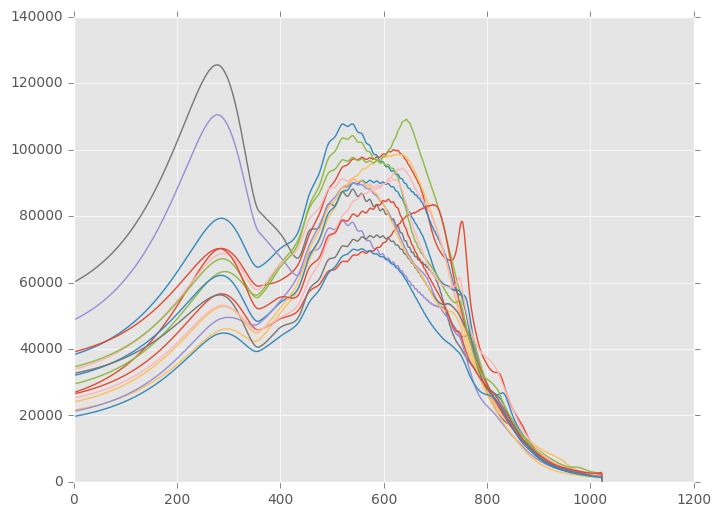

In [24]:
for i in range(16):
    plt.plot(np.mean(newdata[:,i*1024:(i+1)*1024], axis=0))

In [ ]:
X, Y = dataio.reload_with_labels(basedir + 'vec_1478816228.31.npy')
X = np.nan_to_num(X)

In [ ]:
X.shape

In [ ]:
reload(dataio)
nx = janky_subdiv(X)
nx = nx - np.mean(nx, axis=0)
nx = nx / np.std(nx, axis=0)
folder = dataio.UnbalancedStratifier(nx, Y, nFolds=1)
folder.summary()

In [ ]:
datasets = [n for n in folder.gimme()]

In [ ]:
[(ds[0][0].shape, ds[0][1].shape, ds[1][0].shape, ds[1][1].shape) for ds in datasets]

In [ ]:
d0 = data_train * name_mask.reshape([6041,1,1])
d1 = data_train* ~name_mask.reshape([6041,1,1])
n0, n1 = np.count_nonzero(d0[:,512,0]), np.count_nonzero(d1[:,512,0])
print(n0, n1)

In [ ]:
if PLOT: plt.plot(np.mean(np.mean(data_train, axis=2)==0, axis=1))

In [ ]:
if PLOT: plt.plot(np.mean(data_train, axis=0))
'Average (LOGT) power by channel'

In [ ]:
if PLOT: plt.plot(np.sum(d0, axis=0) / n0, c='k')
if PLOT: plt.plot(np.sum(d1, axis=0) / n1, c='r')

'data set 0 vs 1'


In [ ]:
if PLOT: plt.plot(np.mean(np.sum(d0, axis=0) / n0, axis=1), c='k')
if PLOT: plt.plot(np.mean(np.sum(d1, axis=0) / n1, axis=1), c='r')

# NICE!

In [ ]:
data_train = X.reshape((6041, 1024, 16)) # note, this is now unsorted

In [ ]:
 # avg along electrodes
# simple_dtrain = np.mean(data_train, axis=2)
# simple_dtest = np.mean(data_test, axis=2)

# This is the crazy ass wacky shit that seems to make the classifer work at all in the first place

subdiv = 64
start = 1
simple_dtrain = data_train[:,start::subdiv,:].reshape(-1,1024*16//subdiv)
# simple_dtrain = janky_subdiv(data_train)
print(data_train.shape)
simple_dtest = data_test[:,start::subdiv,:].reshape(-1,1024*16//subdiv)

# Normalize ghetto style - THIS IS VERY SUSPECT
simple_dtrain -= np.mean(simple_dtrain)
simple_dtest -= np.mean(simple_dtest)
simple_dtrain /= np.std(simple_dtrain)
simple_dtest /= np.std(simple_dtest)
print(simple_dtrain.shape, simple_dtest.shape)

In [ ]:
plt.plot(simple_dtrain[3])

In [ ]:
y = np.vstack([name_mask, ~name_mask]).T # label vector will be (N, S), N hot for 'no seiz', S hot for 'seize'
print(y.shape)

In [ ]:
dtrain_set = np.concatenate([simple_dtrain, y], axis=1)
dtrain_set.shape

In [ ]:
dframe = pd.DataFrame(dtrain_set)

In [ ]:
d0 = dframe[dframe.iloc[:,-1] == 0]
d1 = dframe[dframe.iloc[:,-1] == 1]
print(d0.shape, d1.shape)
nfalse, nhit = d0.shape[0], d1.shape[0]

In [ ]:
offset = np.random.randint(0, nfalse-nhit-1)
d0b = d0[offset:offset+nhit]
print(d0b.shape)

In [ ]:
d0b_ = d0b.as_matrix()
d1_ = d1.as_matrix()

d1_

### Shuffle and shit

In [ ]:
simple_dtrain.shape

In [ ]:
subdiv_vec =1
# new_set = np.concatenate([d0b_, d1_], axis=0) # this may go weird
new_set = 
print(new_set.shape)
np.random.shuffle(new_set)
print(np.mean(new_set[:nhit,-1]))
simple_dtrain= new_set[:,:-2]
simple_dtrain_lab = new_set[:,-1]
simple_dtrain = simple_dtrain[:,::subdiv_vec]
print(simple_dtrain.shape)
print(np.mean(simple_dtrain_lab[:nhit]))


In [ ]:
np.mean(new_set[:,-4:], axis=0), np.mean(simple_dtrain[:,-3:], axis=0)

In [ ]:
plt.plot(np.mean(new_set, axis=0))
plt.plot(np.mean(simple_dtrain, axis=0))

In [ ]:
N = len(simple_dtrain)
plt.scatter([np.arange(256),]*N, simple_dtrain[:N], s=5)

In [ ]:
pd.Series(simple_dtrain[:,-1]).hist()

In [ ]:
plt.plot(simple_dtrain[0])
plt.plot(simple_dtest[0])

In [ ]:
plt.plot(np.std(simple_dtrain, axis=0))

In [ ]:
print(simple_dtrain.shape, Y.shape, np.mean(Y), type(simple_dtrain))

In [ ]:
# Parition the data into training and evaluation sets
partition = 3*simple_dtrain.shape[0] // 4
# Build 3 layer DNN with 10, 20, 10 units respectively.
nn0 = simple_dtrain.shape[1]
nn1 = 2* nn0
nn2 = nn0

In [ ]:
X=simple_dtrain[:partition]
Y=simple_dtrain_lab[:partition]
Xv=simple_dtrain[partition:]
Yv=simple_dtrain_lab[partition:]

In [ ]:
folder =  dataio.UnbalancedStratifier(simple_dtrain, Y, nFolds=2)
datasets = [n for n in folder.gimme()]

In [ ]:
type(datasets), len(datasets)

In [ ]:
(xt, yt), (xv, yv) = datasets[0]
(xt1, yt1), (xv1, yv1) = datasets[1]

In [ ]:
print(yt.shape, np.mean(yt), np.mean(yv))
print(xt.shape, xv.shape, yt.shape, yv.shape)

In [ ]:
assert 0 # break point

In [ ]:
# Classification
# def do_a_graph():
# with tf.Graph().as_default(): # re-initializing the cells fucks shit up yo
tf.reset_default_graph()
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5) # DO ONLY ONCE!

net = tflearn.input_data(shape=[None, nn0])
net = tflearn.fully_connected(net, 10)
# net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

model = tflearn.DNN(net)
model.fit(X, Y.reshape(-1,1),n_epoch=1)
# model.save('model')
    #     return model

In [ ]:
# with tf.Graph().as_default(): 
#     model.load('model')
ev = model.evaluate(Xv, Yv.reshape(-1,1))
print(ev)

In [ ]:
ev

In [ ]:
pr = model.predict(simple_dtest)

In [ ]:
pr_ = np.array(pr)

In [ ]:
np.mean(pr_[:,0])

In [ ]:
pr_.shape

In [ ]:
guess = pr_[:,1] > .5
guess

In [ ]:
names_test['guess'] = pd.Series(pr_[1,:])

In [ ]:
names_test['']

In [ ]:
perc = lm.Perceptron()

In [ ]:
perc.fit(X, Y)

In [ ]:
perc.score(Xv, Yv)

In [ ]:
pr = perc.predict(simple_dtest[:,::16])
print(pr.mean())

In [ ]:
names_test['guess'] = pd.Series(pr)

In [ ]:
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
names_test.to_csv('guess11_10_perc.csv')

In [ ]:
ls

# SKLearn MLP

In [ ]:
X256 = janky_subdiv(X)

In [ ]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)
print(xt.shape, yt.shape)

In [ ]:
mlp.fit(xt, yt)

In [ ]:
mlp.score(xt, yt), mlp.score(xv, yv), 

In [ ]:
mlp.score(xt1, yt1)

In [ ]:
print(np.mean(yt, axis=0))

In [ ]:
backcheck = mlp.predict(xt)
print(np.mean(backcheck, axis=0))

In [ ]:
np.mean(backcheck == yt)

In [ ]:
reload(dataio)

In [ ]:
fold_mlp = dataio.UnbalancedStratifier(X, Y,mandateZerosExcess=0)
fold_mlp.summary()

In [ ]:
print(np.mean(mlp.predict(Xv), axis=0))
print(np.mean(Yv, axis=0))

In [ ]:
pr = mlp.predict(simple_dtest)
print(pr.mean())

In [ ]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_256.csv', index=False)

In [ ]:
mlp_z = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)

In [ ]:
robuster = preproc.RobustScaler()

In [ ]:
robuster.fit(X, Y)

In [ ]:
X_r = robuster.fit_transform(X)
Xv_r = robuster.fit_transform(Xv)

In [ ]:
mlp.fit(X_r, Y)
mlp.score(Xv_r, Yv)

In [ ]:
pred = mlp.predict(Xv)
np.mean(pred, axis=0), np.mean(Yv, axis=0)

# K-Fold MLP

In [ ]:
models = [nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1) for i in range(10)]

In [ ]:
K=2
(xt, yt), (xv, yv) = datasets[0]
print(xt.shape, yt.shape, xv.shape, yv.shape)

In [ ]:
for i in range(K):
    (xt, yt), (xv, yv) = datasets[i]
    models[i].fit(xt, yt)
    print(models[i].score(xv, yv), np.mean(models[i].predict(xv), axis=0))

In [ ]:
for i in range(K):
    print(np.mean(models[i].predict(X), axis=0))

In [ ]:
for i in range(10):
    (xt, yt), (xv, yv) = datasets[i]
    print(np.mean(yt, axis=0), np.mean(yv, axis=0))

# Sparse PCA

In [ ]:
from sklearn import decomposition

In [ ]:
foo = decomposition.SparsePCA(16)

In [ ]:
foo.fit(X, Y)

In [ ]:
foo.components_

In [ ]:
foo.components_.shape

In [ ]:
xprime = foo.transform(X)

In [ ]:
xprime.shape

In [ ]:
plt.plot(np.mean(xprime, axis=0))

In [ ]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(512,16,4), activation='relu', warm_start=1)

In [ ]:
mlp.fit(xprime, Y)
print(mlp.score(foo.transform(Xv), Yv))
pr = mlp.predict(foo.transform(simple_dtest))
print(pr.mean())

In [ ]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_pca16.csv', index=False)